Scope of Project:
    
1. Camera Calibration
2. Distortion Correction
3. Color and Gradient Threshold
4. Perspective Transform
5. Detect Lane Lines
6. Determine Lane Curvature
7. Impose Lane Boundaries on Original Image
8. Output Visual Display of Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position


### Import Modules

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
from moviepy.editor import VideoFileClip
import math
# For cordinate isolation
#%matplotlib qt  

%matplotlib inline

### Global Variables and Classes

In [2]:
class Error(Exception):
    pass
        
global polygon, area

### 1. Camera Calibration

In [3]:
## Compute camera calibration matrix and distortion coefficients.

def camera_Calibraton(directory, filename, nx, ny, img_size):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob2.glob('./'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

### 2. Distortion Correction

In [4]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

#### Test Image Distortion

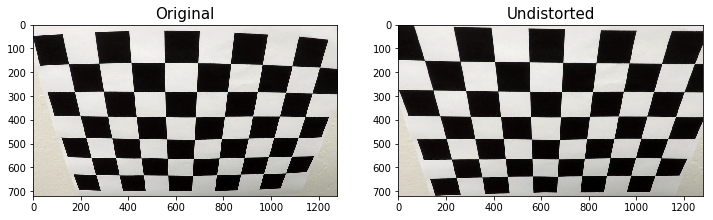

In [5]:
mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
checker_dist = mpimg.imread("./camera_cal/calibration2.jpg")
checker_undist = undistort(checker_dist, mtx, dist)



f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(checker_dist)
ax1.set_title('Original', fontsize=15)
ax2.imshow(checker_undist)
ax2.set_title('Undistorted', fontsize=15)

### 3. Color and Gradient Threshold

In [6]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert(orient == 'x' or orient == 'y'), "Orientation must be x or y"
    
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.power((np.power(sobelx,2)+np.power(sobely,2)),0.5)
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def channel_Isolate(image,channel):
    ## Takes in only RBG images
    if (channel == 'R'):
        return image[:,:,0]
    
    elif (channel == 'G'):
        return image[:,:,1]
    
    elif (channel == 'B'):
        return image[:,:,2]
    
    elif (channel == 'H'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,0]
    
    elif (channel == 'S'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,1]
        
    elif (channel == 'V'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,2]
        
    elif (channel == 'L'):
        HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return HLS[:,:,1]
    
    elif (channel == 'Cb'):
        YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        return YCrCb[:,:,2]
    
    elif (channel == 'U'):
        LUV = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        return LUV[:,:,2]
    
    else:
        raise Error("Channel must be either R, G, B, H, S, V, L, Cb, U")
    
def threshold_Channel(channel,thresh):
    retval, binary = cv2.threshold(channel.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

### 4. Perspective Transform

In [7]:
def transform(undist,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

### 5. Detect Lane Lines

In [8]:
def find_lines(img):
    right_side_x = []
    right_side_y = []
    left_side_x = []
    left_side_y = []  
    
    past_cord = 0
    
    # right side
    for i in reversed(range(10,100)):
        histogram = np.sum(img[i*img.shape[0]/100:(i+1)*img.shape[0]/100,img.shape[1]/2:], axis=0) 
        xcord = int(np.argmax(histogram)) + 640
        ycord = int(i*img.shape[0]/100)
        if (i == 50):
            right_lane_dp = (xcord)
        if (ycord == 0 or xcord == 0):
            pass
        elif (abs(xcord-past_cord) > 100 and not(i == 99) and not( past_cord == 0)):
            pass
        elif (xcord == 640):
            pass
        else:
            right_side_x.append(xcord)
            right_side_y.append(ycord)
            past_cord = xcord

    past_cord = 0
    # left side
    for i in reversed(range(10,100)):
        histogram = np.sum(img[i*img.shape[0]/100:(i+1)*img.shape[0]/100,:img.shape[1]/2], axis=0)
        xcord = int(np.argmax(histogram))
        ycord = int(i*img.shape[0]/100)
        if (i == 50):
            left_lane_dp = (xcord)
        if (ycord == 0 or xcord == 0):
            pass
        elif (abs(xcord-past_cord) > 100 and not(i == 99) and not(past_cord == 0)):
            pass
        else:
            left_side_x.append(xcord)
            left_side_y.append(ycord)
            past_cord = xcord
    
    left_line =  (left_side_x,left_side_y)
    right_line = (right_side_x,right_side_y)
    
    left_line =  (left_line[0][1:(len(left_line[0])-1)],left_line[1][1:(len(left_line[1])-1)])
    right_line = (right_line[0][1:(len(right_line[0])-1)],right_line[1][1:(len(right_line[1])-1)])
    
    lane_middle = int((right_lane_dp - left_lane_dp)/2.)+left_lane_dp
    
    if (lane_middle-640 > 0):
        leng = 3.66/2
        mag = ((lane_middle-640)/640.*leng)
        head = ("Right",mag)
    else:
        leng = 3.66/2.
        mag = ((lane_middle-640)/640.*leng)*-1
        head = ("Left",mag)

    
    return left_line, right_line, head

### 6. Determine Lane Curvature

In [9]:
def lane_curve(left_line,right_line):

    degree_fit = 2
    
    fit_left = np.polyfit(left_line[1], left_line[0], degree_fit)
    fit_right = np.polyfit(right_line[1], right_line[0], degree_fit)
    x = [xi * (3.7/700.) for xi in left_line[0]]
    x1 = []
    for item in left_line[0]:
        x1.append(item*(3.7/700.))
        
    y = [x * (30/720.) for x in left_line[1]]
    y1 = []
    for item in left_line[1]:
        y1.append(item*(30/720.))
    curve = np.polyfit(y1, x1, degree_fit)
    return fit_left, fit_right, curve

### 7. Impose Lane Boundaries on Original Image

In [10]:
def impose_Lane_Area(undist, fit_left, fit_right, trans, src, dst, img_size, curve):
    
    global left_points,right_points
    
    left_points  = []
    right_points = []

    left = np.poly1d(fit_left)
    right = np.poly1d(fit_right)

    rad_curve = ((1 + (2*curve[0]*710/2 + curve[1])**2)**1.5)/np.absolute(2*curve[0])  
 
    for i in range(100,710,2):
        if (int(left(i)<0)):
            pass
        else:
            left_points.append([int(left(i)),i])

    for i in range(100,710,2):
        if (int(right(i)<0)):
            pass
        else:
            right_points.append([int(right(i)),i])

    
    polygon_points = right_points + list(reversed(left_points))
    polygon_points = np.array(polygon_points)

    
    overlay = np.zeros_like(trans)
    trans_image = cv2.fillPoly(overlay, [polygon_points], (0,255,0) )
    
    M = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(trans_image, M, img_size)
    
    area = cv2.contourArea(polygon_points)
    
    #area = 10000000000

    return unwarped, area, rad_curve, polygon_points


### Image Pipeline

In [11]:

def pipeline(image,mtx, dist, dash): 
    global polygon, area, left, right, last, frame_count,polygon_points_old, last, Head_b, rad_curve_b, vehicle_count, IMAGE
    
    frame_count+=1
    
    
    try:
        # Set Parameters
        img_size = (image.shape[1], image.shape[0])
        src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
        dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

        # Run 2
        undist = undistort(image, mtx, dist)

        # Run 4
        trans = transform(undist,src,dst,img_size)

        # Run 3
        red_threshed = threshold_Channel(channel_Isolate(trans,'R'),(220,255))
        V_threshed = threshold_Channel(channel_Isolate(trans,'V'),(220,255))        
        # Cb_tresh = threshold_Channel(channel_Isolate(trans,'Cb'),(200,255))
        HSV = cv2.cvtColor(trans, cv2.COLOR_RGB2HSV)
        yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
        
        sensitivity_1 = 68
        white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

        sensitivity_2 = 60
        HSL = cv2.cvtColor(trans, cv2.COLOR_RGB2HLS)
        white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
        
        white_3 = cv2.inRange(trans, (200,200,200), (255,255,255))
 
        bit_layer = red_threshed | V_threshed | yellow | white | white_2 | white_3
        
        # Run 5
        left_line, right_line, head = find_lines(bit_layer)

        # Run 6 
        fit_left, fit_right, curve = lane_curve(left_line,right_line)
        # Run 7
        unwarped, area, rad_curve, polygon_points = impose_Lane_Area(undist,fit_left, fit_right, trans, src, dst, img_size, curve)
        # Detect
        vehicle_count = 0
    
        ########## Transformation visualization #########
#         return trans
        
    
        ########## Bit layer visualization #########
#         return bit_layer
    
        
        
        if area < 250000:
            
            print ("Error in area")
            
            result = cv2.addWeighted(undist, 1, polygon, 0.3, 0)

            original = undist.copy()

            original[475:720] = result[475:720]

            original[50:130,50:350,:] = dash
        
            font = cv2.FONT_HERSHEY_DUPLEX
            text = last[0]
            cv2.putText(original,text , (256,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

            dist = last[1]
            cv2.putText(original,str(dist) , (181,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

            rad_curve = last[2]
            cv2.putText(original,str(rad_curve) , (244,91), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

            cv2.putText(original,str(last[3]) , (189,111), font, 0.4, (0,0,0), 1, cv2.LINE_AA)
            
            #cv2.putText(original,"AREA ERROR" , (500,500), font, 1, (255,0,0), 1, cv2.LINE_AA)

            return original
        
        

        else:
            ######### Lane points found visualization #########

#             left =  []
#             right = []
              
#             for i in range(len(left_line[0])):
#                 left.append([left_line[0][i],left_line[1][i]])
                
#             for i in range(len(right_line[0])):
#                 right.append([right_line[0][i],right_line[1][i]])
            
#             for point in left:
#                 cv2.circle(trans, (point[0],point[1]), 10, 255, -1)
                
#             for point in right:
#                 cv2.circle(trans, (point[0],point[1]), 10, 255, -1)
   
#             return trans
         
    
            ########## Polyfit visualization #########
            
#             for i in left_points:
#                 cv2.circle(trans, (i[0],i[1]), 10, 255, -1)
#             for i in right_points:
#                 cv2.circle(trans, (i[0],i[1]), 10, 255, -1)
                
#             return trans    

    
    
            ######### Augmented visualization #########
            if polygon_points_old is None:
                polygon_points_old = []
                print(polygon_points_old)
                polygon_points_old = polygon_points
            
            a = polygon_points_old
            b = polygon_points
            ret = 0.
            ret = cv2.matchShapes(np.array(a),np.array(b),1,0.0)     
            original = undist.copy()
            
            font = cv2.FONT_HERSHEY_DUPLEX
                    
            #cv2.putText(original,(str(ret)), (10,300), font, 1, (255,0,0), 1, cv2.LINE_AA)
            
            
            if (ret < 0.045 or IMAGE):
                polygon = unwarped

                result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)
                polygon_points_old = polygon_points
                Head_b = head
                rad_curve_b = rad_curve
                vehicle_count_b = vehicle_count

            else:
                result = cv2.addWeighted(undist, 1, polygon, 0.3, 0)        
                polygon = polygon
                
            original[475:720] = result[475:720]
            
            original[50:130,50:350,:] = dash
                        
            if ((frame_count % 10)== 0):
                font = cv2.FONT_HERSHEY_DUPLEX
                text = Head_b[0]
                cv2.putText(original,text , (256,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                dist = math.ceil(Head_b[1]*100)/100
                cv2.putText(original,str(dist) , (181,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                rad_curve = math.ceil(rad_curve_b*100)/100
                cv2.putText(original,str(rad_curve) , (244,91), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                cv2.putText(original,str(vehicle_count) , (189,111), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                last = [text,dist,rad_curve,vehicle_count]
            
            else:
                font = cv2.FONT_HERSHEY_DUPLEX
                text = last[0]
                cv2.putText(original,text , (256,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                dist = last[1]
                cv2.putText(original,str(dist) , (181,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                rad_curve = last[2]
                cv2.putText(original,str(rad_curve) , (244,91), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

                cv2.putText(original,str(last[3]) , (189,111), font, 0.4, (0,0,0), 1, cv2.LINE_AA)
            
            
            return original 
    
    except Exception as e:
        
        print (e)
        print ("Error in something?")
        
        result = cv2.addWeighted(undist, 1, polygon, 0.3, 0)

        original = undist.copy()

        original[475:720] = result[475:720]
        
        original[50:130,50:350,:] = dash
        
        font = cv2.FONT_HERSHEY_DUPLEX
        text = last[0]
        cv2.putText(original,text , (256,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

        dist = last[1]
        cv2.putText(original,str(dist) , (181,71), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

        rad_curve = last[2]
        cv2.putText(original,str(rad_curve) , (244,91), font, 0.4, (0,0,0), 1, cv2.LINE_AA)

        cv2.putText(original,str(last[3]) , (189,111), font, 0.4, (0,0,0), 1, cv2.LINE_AA)
        
        #cv2.putText(original,"DROP ERROR" , (500,500), font, 1, (255,0,0), 1, cv2.LINE_AA)
        
        return original
    


### Test

In [12]:
# Parameters
directory = 'camera_cal'
filename = 'calibration'
nx = 9 
ny = 6
cal_img_size = (720, 1280)

# Run 1  (Run once to save time)
mtx, dist = camera_Calibraton(directory, filename, nx, ny, cal_img_size)

[]


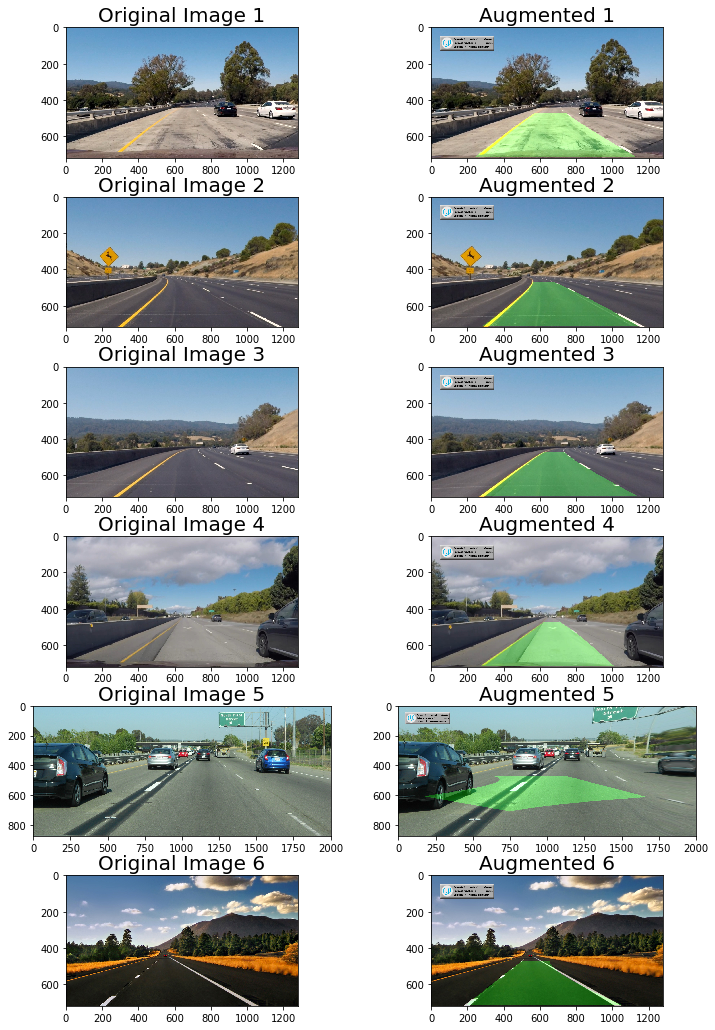

In [14]:
# Establish Inital Frame Count
frame_count = 10
polygon_points_old = None
IMAGE = True
last = ["i","i","i","i"]

# Read In Data Project Video
image_1 = mpimg.imread("./test_images/test1.jpg")
image_2 = mpimg.imread("./test_images/test2.jpg")
image_3 = mpimg.imread("./test_images/test3.jpg")
image_4 = mpimg.imread("./test_images_1/test3.jpg")
image_5 = mpimg.imread("./test_images/1.jpg")
image_6 = mpimg.imread("./test_images/43962-highway.jpg")


# # # Read In Data Harder Video
# image_1 = mpimg.imread("./test_images_1/test1.jpg")
# image_2 = mpimg.imread("./test_images_1/test2.jpg")
# image_3 = mpimg.imread("./test_images_1/test3.jpg")
# image_4 = mpimg.imread("./test_images_1/test4.jpg")
# image_5 = mpimg.imread("./test_images_1/test5.jpg")
# image_6 = mpimg.imread("./test_images_1/test6.jpg")

# # Read In Data Hardest Video
# image_1 = mpimg.imread("./test_images_2/test1.jpg")
# image_2 = mpimg.imread("./test_images_2/test2.jpg")
# image_3 = mpimg.imread("./test_images_2/test3.jpg")
# image_4 = mpimg.imread("./test_images_2/test4.jpg")
# image_5 = mpimg.imread("./test_images_2/test5.jpg")
# image_6 = mpimg.imread("./test_images_2/test6.jpg")

# Import Dash Interface
dash = mpimg.imread("./Dash.jpg")


# Run pipline on images

Image_1 = pipeline(image_1, mtx, dist, dash)
Image_2 = pipeline(image_2, mtx, dist, dash)
Image_3 = pipeline(image_3, mtx, dist, dash)
Image_4 = pipeline(image_4, mtx, dist, dash)
Image_5 = pipeline(image_5, mtx, dist, dash)
Image_6 = pipeline(image_6, mtx, dist, dash)


# Single Image View
# plt.figure(figsize=(460,440))
# plt.imshow(Image_3, cmap="gray")


f, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(12, 18))
ax1.imshow(image_1)
ax1.set_title('Original Image 1', fontsize=20)
ax2.imshow(Image_1)
ax2.set_title('Augmented 1', fontsize=20)
ax3.imshow(image_2)
ax3.set_title('Original Image 2', fontsize=20)
ax4.imshow(Image_2)
ax4.set_title('Augmented 2', fontsize=20)
ax5.imshow(image_3)
ax5.set_title('Original Image 3', fontsize=20)
ax6.imshow(Image_3)
ax6.set_title('Augmented 3', fontsize=20)
ax7.imshow(image_4)
ax7.set_title('Original Image 4', fontsize=20)
ax8.imshow(Image_4)
ax8.set_title('Augmented 4', fontsize=20)
ax9.imshow(image_5)
ax9.set_title('Original Image 5', fontsize=20)
ax10.imshow(Image_5)
ax10.set_title('Augmented 5', fontsize=20)
ax11.imshow(image_6)
ax11.set_title('Original Image 6', fontsize=20)
ax12.imshow(Image_6)
ax12.set_title('Augmented 6', fontsize=20)

plt.subplots_adjust(hspace=0.3)


In [19]:
#########################################################################################

In [20]:
# Video writer
polygon_points_old = None
last = ["i","i","i","i"]
IMAGE = False

Head_b = [0,0]
rad_curve_b = 0
vehicle_count_b = 0

frame_count = 0

output = 'challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(lambda img: pipeline(img, mtx, dist, dash))
%time clip.write_videofile(output, audio=False)

IOError: MoviePy error: the file challenge_video.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
#########################################################################################